# IBM Datascience Capstone
## Analysing Berling AirBnB rental Datascience

We're using the [Berlin AirBnB](https://www.kaggle.com/brittabettendorf/berlin-airbnb-data) dataset to evaluate two questions:

1. Which neighbourhood attracts high-paying tourists?
2. Is location really everything?

These questions are important for city planning with several regards. Positive aspects on tourism include attracting cashflow to local businesses. However, AirBnB can attract commercial usage of living space that should be available to normal tenants and therefore contribute to shortages and price hikes in apartments in popular cities and areas.

We'll start out with importing, loading and cleaning the data. I decided to exclude AirBnB offers over 1000 Euro per night for visualization purposes. The long tail (up to 9000 Euro) makes the plots quite unreadable.

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import folium
from folium import plugins

In [3]:
berlin_raw = pd.read_csv("data/listings.csv")
berlin_raw.neighbourhood_group = berlin_raw.neighbourhood_group.str.replace(" ", "")
berlin_raw.neighbourhood_group = berlin_raw.neighbourhood_group.str.replace("Charlottenburg-Wilm.", "Charlottenburg-Wilmersdorf")
berlin_airbnb = berlin_raw[berlin_raw.price > 0] # Price 0 seems buggy
berlin_airbnb = berlin_airbnb[berlin_airbnb.price < 1000] # To get around the long tail outliers
berlin_airbnb[["neighbourhood_group", "neighbourhood", "room_type"]] = berlin_airbnb[["neighbourhood_group", "neighbourhood", "room_type"]].astype("category")

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Ian,Mitte,Brunnenstr. Süd,52.534537,13.402557,Entire home/apt,60,4,118,2018-10-28,3.76,4,141
1,2695,Prenzlauer Berg close to Mauerpark,2986,Michael,Pankow,Prenzlauer Berg Nordwest,52.548513,13.404553,Private room,17,2,6,2018-10-01,1.42,1,0
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.534996,13.417579,Entire home/apt,90,62,143,2017-03-20,1.25,1,220
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof-Schöneberg,Schöneberg-Nord,52.498855,13.349065,Private room,26,5,25,2018-08-16,0.39,1,297
4,7071,BrightRoom with sunny greenview!,17391,Bright,Pankow,Helmholtzplatz,52.543157,13.415091,Private room,42,2,197,2018-11-04,1.75,1,26


In [4]:
berlin_airbnb.shape

(22503, 16)

In [5]:
berlin_airbnb.room_type.unique()

[Entire home/apt, Private room, Shared room]
Categories (3, object): [Entire home/apt, Private room, Shared room]

In [6]:
berlin_airbnb.neighbourhood_group.unique()

[Mitte, Pankow, Tempelhof-Schöneberg, Friedrichshain-Kreuzberg, Neukölln, ..., Steglitz-Zehlendorf, Reinickendorf, Lichtenberg, Marzahn-Hellersdorf, Spandau]
Length: 12
Categories (12, object): [Mitte, Pankow, Tempelhof-Schöneberg, Friedrichshain-Kreuzberg, ..., Reinickendorf, Lichtenberg, Marzahn-Hellersdorf, Spandau]

The dataset contains 22503 individual appartments on AirBnB in a city with 1.95 million apartments total. The dataset shows 12 different neighbourhoods and some review data, as well as, exact location of each. Therefore, a geospatial analysis will be quite interesting.

## Exploratory Data analysis
We can now explore the data and analyze how different areas are represented in the data. In the first map map we explore the average price of AirBnB lettings per neighbourhood. 

In [7]:
berlin_airbnb["price_norm"] = (berlin_airbnb.price-berlin_airbnb.price.min())/(berlin_airbnb.price.max()-berlin_airbnb.price.min())

In [8]:
berlin_lat = berlin_airbnb.latitude.mean()
berlin_long = berlin_airbnb.longitude.mean()
colors = ["#3333DD", "#B00000"]

In [9]:
berlin_map = folium.Map(location=[berlin_lat, berlin_long], zoom_start=10)

belin_boroughs = "https://raw.githubusercontent.com/funkeinteraktiv/Berlin-Geodaten/master/berlin_bezirke.geojson"
berlin_price = berlin_airbnb.groupby(by="neighbourhood_group").median().reset_index()

folium.Choropleth(
    geo_data=belin_boroughs,
    name='choropleth',
    data=berlin_price,
    columns=['neighbourhood_group', 'price'],
    key_on='feature.properties.name',
    fill_color='RdBu_r',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend = "Median Price (Euro)"
).add_to(berlin_map)

folium.LayerControl().add_to(berlin_map)

berlin_map


In [10]:
berlin_map = folium.Map(location=[berlin_lat, berlin_long], zoom_start=10)

belin_boroughs = "https://raw.githubusercontent.com/funkeinteraktiv/Berlin-Geodaten/master/berlin_bezirke.geojson"
berlin_price = berlin_airbnb.groupby(by="neighbourhood_group").mean().reset_index()

folium.Choropleth(
    geo_data=belin_boroughs,
    name='choropleth',
    data=berlin_price,
    columns=['neighbourhood_group', 'price'],
    key_on='feature.properties.name',
    fill_color='RdBu_r',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend = "Mean Average Price (Euro)"
).add_to(berlin_map)

folium.LayerControl().add_to(berlin_map)

berlin_map


We can see that central locations are especially expensive, with some of the East/West divide still existing. It is also visible that Tegel airport is somewhat of a barrier behind which there is a low-cost AirBnB neighbourhood (and a lot of forests and not a lot of public transportation). There is a clear discrepancy betweenthe mean and median data. It seems Kreuzberg has some really cheap flats available but most commonly it is just as expensive as Mitte.

But let's have a look at the distributions of price. Is it really just about location?

Text(0.5, 1.0, 'Berlin AirBnB Price distribution')

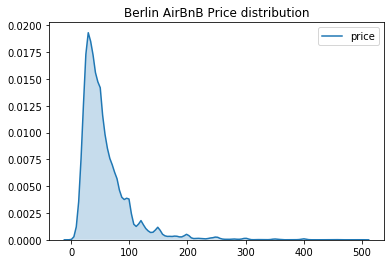

In [11]:
sns.kdeplot(berlin_airbnb.price, shade=True, clip=(0, 500))
plt.title("Berlin AirBnB Price distribution")

Text(0.5, 1.0, 'Interesting Aside: At higher prices increments change to 50s')

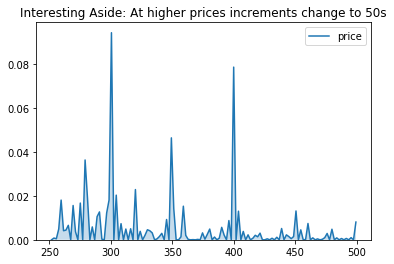

In [12]:
sns.kdeplot(berlin_airbnb.price, bw=.1, shade=True, clip=(250, 500))
plt.title("Interesting Aside: At higher prices increments change to 50s")

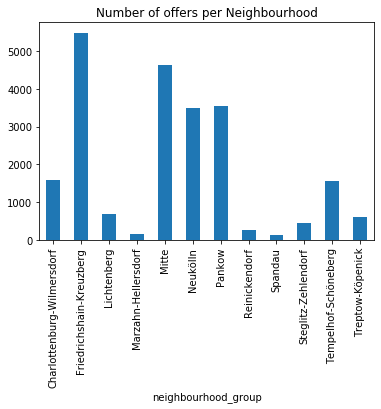

In [13]:
berlin_airbnb.groupby(by="neighbourhood_group").id.count().plot(kind="bar", title="Number of offers per Neighbourhood")

Text(0.5, 1.0, 'AirBnB Price per Neighbourhood Berlin')

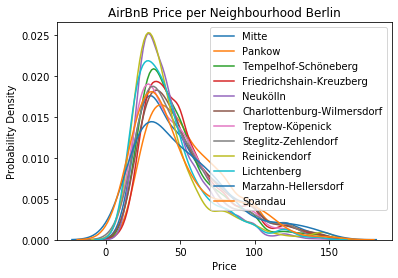

In [14]:
# Plotting the KDE Plot 
for hood in berlin_airbnb.neighbourhood_group.unique():
    sns.kdeplot(berlin_airbnb[berlin_airbnb.neighbourhood_group==hood].price, shade=False, clip=(0, 150), Label=hood)

  
plt.xlabel('Price') 
plt.ylabel('Probability Density') 
plt.title('AirBnB Price per Neighbourhood Berlin')

The distributions are remarkably similar! Yes Mitte and Pankow (central districts) are somewhat wider, but that's also due to the number of available lettings. The very sharp spike is Reinickendorf, which does not have many offers on AirBnB. Generally, the spikes are in very similar areas below 100€. An interesting outlier is Frierichhain-Kreuzberg, which has a second peak close to 50€. So what is causing the divide between places actually?

There seems to be a slight bias, but is that actually enough? How about we compare the type of letting. People generally pay less for staying in a shared room.

## Type of apartment

- puple:  Entire Apartment
- green:  Private Room
- yellow: Shared Room

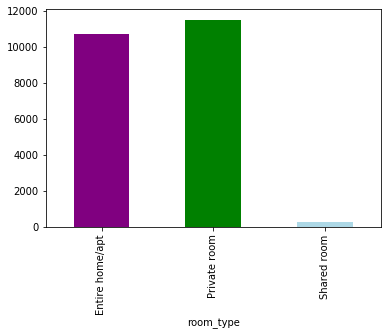

In [27]:
colors = ["purple", "green", "lightblue"]
features = ["neighbourhood_group", "room_type", "price", "number_of_reviews", "reviews_per_month"]

berlin_airbnb.groupby(by="room_type").count().id.plot(kind="bar", color=colors)

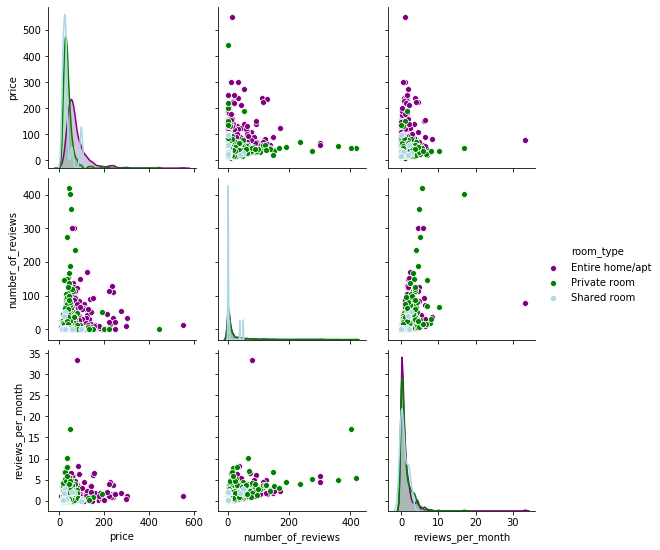

In [28]:
sns.pairplot(berlin_airbnb[features].sample(1000), hue="room_type", palette=colors)

Now this looks like a difference. The data on room type shows a change in the price distribution! Shared rooms tend to have fewer reviews and a lower rate of monthly reviews. A lot more full apartment lettings have a lot more reviews! The 500 Euro lettings have 100 of reviews even. How are these room types distributed then?

In [39]:
heatmap = folium.Map(location=[berlin_lat, berlin_long], zoom_start=12, tiles='Stamen Toner',)

# plot heatmap
heatmap.add_children(folium.plugins.HeatMap(berlin_airbnb[berlin_airbnb.room_type == "Entire home/apt"][['latitude', 'longitude']].values, radius=15))
heatmap

In [40]:

heatmap = folium.Map(location=[berlin_lat, berlin_long], zoom_start=12, tiles='Stamen Toner',)

# plot heatmap
heatmap.add_children(folium.plugins.HeatMap(berlin_airbnb[berlin_airbnb.room_type == "Private room"][['latitude', 'longitude']].values, radius=15))
heatmap

So that's interesting, there are a lot of full apartments available in Mitte, whereas private rooms are more common toward the east. Shared apartments are sprinkled across Berlin, but then again there was not a lot of data available. Let's look at the price distribution by apartment type in detail to finish this out. And see how many apartment types are in each neighbourhood.

Text(0.5, 1.0, 'AirBnB Price per Room Type')

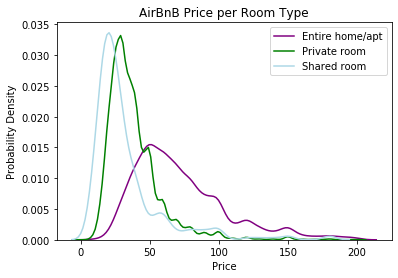

In [41]:
# Plotting the KDE Plot 
for i, room in enumerate(berlin_airbnb.room_type.unique()):
    sns.kdeplot(berlin_airbnb[berlin_airbnb.room_type==room].price, shade=False, clip=(0, 200), Label=room, color=colors[i])
  
plt.xlabel('Price') 
plt.ylabel('Probability Density') 
plt.title('AirBnB Price per Room Type')

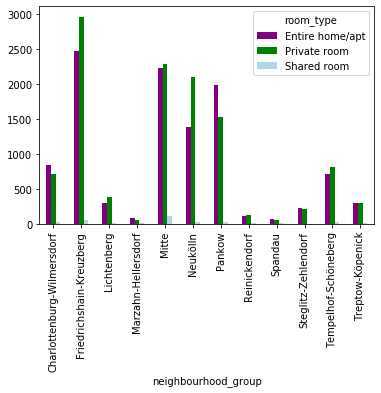

In [42]:
pd.pivot_table(berlin_airbnb, index="neighbourhood_group", columns="room_type", values='id', aggfunc='count').plot(kind = 'bar', color=colors)

## Modeling Step

Let's build a linear model to predict price and round it off with a random forest model that works well on categorical features. We also have to consider that the classes are relatively unbalanced, regarding distribution among neighbourhoods.

In [43]:
df_train = pd.get_dummies(berlin_airbnb[["neighbourhood_group", "room_type"]])
target = berlin_airbnb["price"]

In [44]:
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

In [45]:
scores = []
mse = []
skf = StratifiedKFold(n_splits=10)
for train, test in skf.split(df_train, target):
    clf = LinearRegression()
    clf.fit(df_train.iloc[train], target.iloc[train])
    scores.append(clf.score(df_train.iloc[test], target.iloc[test]))
    mse.append(mean_squared_error(target.iloc[test], clf.predict(df_train.iloc[test])))

print("Average R2 score: \t", np.mean(scores),)
print("Average MSE: \t\t", np.mean(mse), "\n")

r = permutation_importance(clf, df_train.iloc[test], target.iloc[test],
                           n_repeats=30,
                           random_state=0)

print("Normalized importances")
sorted_idx = r.importances_mean.argsort()
max_i = sorted_idx[-1]

rel_max = r.importances_mean[max_i]

for i in sorted_idx[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_train.columns[i]:<50}"
              f"{r.importances_mean[i]/rel_max:.3f}"
              f" +/- {r.importances_std[i]/rel_max:.3f}")

Average R2 score: 	 0.1688816089848335
Average MSE: 		 2146.3158415682396 

Normalized importances
room_type_Private room                            1.000 +/- 0.020
room_type_Entire home/apt                         0.984 +/- 0.018
neighbourhood_group_Friedrichshain-Kreuzberg      0.219 +/- 0.005
neighbourhood_group_Mitte                         0.212 +/- 0.004
neighbourhood_group_Pankow                        0.148 +/- 0.003
neighbourhood_group_Neukölln                      0.141 +/- 0.003
room_type_Shared room                             0.100 +/- 0.002
neighbourhood_group_Charlottenburg-Wilmersdorf    0.099 +/- 0.002
neighbourhood_group_Tempelhof-Schöneberg          0.092 +/- 0.002
neighbourhood_group_Lichtenberg                   0.058 +/- 0.001
neighbourhood_group_Steglitz-Zehlendorf           0.036 +/- 0.001
neighbourhood_group_Treptow-Köpenick              0.033 +/- 0.001
neighbourhood_group_Reinickendorf                 0.014 +/- 0.000
neighbourhood_group_Spandau                

In [46]:
scores = []
mse = []
skf = StratifiedKFold(n_splits=10)
for train, test in skf.split(df_train, target):
    clf = RandomForestRegressor()
    clf.fit(df_train.iloc[train], target.iloc[train])
    scores.append(clf.score(df_train.iloc[test], target.iloc[test]))
    mse.append(mean_squared_error(target.iloc[test], clf.predict(df_train.iloc[test])))

print("Average R2 score: \t", np.mean(scores),)
print("Average MSE: \t\t", np.mean(mse), "\n")

r = permutation_importance(clf, df_train.iloc[test], target.iloc[test],
                           n_repeats=30,
                           random_state=0)

print("Normalized importances")
sorted_idx = r.importances_mean.argsort()
max_i = sorted_idx[-1]

rel_max = r.importances_mean[max_i]

for i in sorted_idx[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_train.columns[i]:<50}"
              f"{r.importances_mean[i]/rel_max:.3f}"
              f" +/- {r.importances_std[i]/rel_max:.3f}")

Average R2 score: 	 0.17304609190808978
Average MSE: 		 2135.732191803595 

Normalized importances
room_type_Entire home/apt                         1.000 +/- 0.060
neighbourhood_group_Mitte                         0.055 +/- 0.010
neighbourhood_group_Neukölln                      0.022 +/- 0.010
room_type_Private room                            0.009 +/- 0.003
neighbourhood_group_Lichtenberg                   0.008 +/- 0.003
neighbourhood_group_Charlottenburg-Wilmersdorf    0.005 +/- 0.002
neighbourhood_group_Reinickendorf                 0.005 +/- 0.002


In [47]:
mse = []
scores = []
skf = StratifiedKFold(n_splits=10)
enc = OrdinalEncoder()

df_rf = berlin_airbnb[["neighbourhood_group", "room_type"]]

enc.fit(df_rf)

for train, test in skf.split(df_rf, target):
    clf = RandomForestRegressor()
    clf.fit(enc.transform(df_rf.iloc[train]), target.iloc[train])
    scores.append(clf.score(enc.transform(df_rf.iloc[test]), target.iloc[test]))
    mse.append(mean_squared_error(target.iloc[test], clf.predict(enc.transform(df_rf.iloc[test]))))

print("Average R2 score: \t", np.mean(scores),)
print("Average MSE: \t\t", np.mean(mse), "\n")

r = permutation_importance(clf, enc.transform(df_rf.iloc[test]), target.iloc[test],
                           n_repeats=30,
                           random_state=0)

print("Normalized importances")
sorted_idx = r.importances_mean.argsort()
max_i = sorted_idx[-1]

rel_max = r.importances_mean[max_i]

for i in sorted_idx[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{df_rf.columns[i]:<50}"
              f"{r.importances_mean[i]/rel_max:.3f}"
              f" +/- {r.importances_std[i]/rel_max:.3f}")

Average R2 score: 	 0.17313509460384474
Average MSE: 		 2135.522463772174 

Normalized importances
room_type                                         1.000 +/- 0.060
neighbourhood_group                               0.119 +/- 0.017


## Conclusion

The initial analysis showed that the price of an AirBnB let is in part influenced by the centrality, but that type of room may have an even larger influence on the price. The geospatial analysis shows that more full apartments are available in Mitte and more private rooms are available in Kreuzberg. The linear regression model shows that prices can be predicted with a moderate R2 score of ~0.17 using location and room type. Using the permutation importance the most important features are in fact whether a room is private or a full apartment, all other features being 5 times less influential on the prediction result. This suggests the initial analysis was in fact correct. The non-linear Random Forest model confirms this idea, with a slightly better R2 score, where centrality of the apartment and whether the entire apartment was available are the main predictive features. Considering the similar performance of both models it is advisable to use the simpler linear model over the non-linear model. If more features are important it may be good to use Random Forests because ordinal categories (as shown in the last code cell) are possible.